# Question 3

**Question: Predict the SalePrice using important features. Using machine learning.**

In [1]:
#import some necessary librairies
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
#ignore annoying warning (from sklearn and seaborn)
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
from scipy import stats
from scipy.stats import norm, skew
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [2]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import Imputer, LabelEncoder

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge, BayesianRidge, LassoLarsIC, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA, KernelPCA

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
import xgboost
from sklearn.pipeline import Pipeline, make_pipeline

# Data Preprocessing

**1. read data**

In [3]:
#read training data and test data into pandas dataframe
# we don't know the saleprice of the houses in test data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


**2. delete unnecessary ID column**

In [4]:
#Save the 'Id' column
train_ID, test_ID = train['Id'], test['Id']

#Now drop the  'Id' colum since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("The train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


**3. delete outliers**

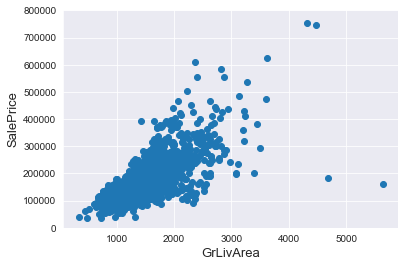

In [5]:
# GrLivArea: Above grade (ground) living area square feet
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.ylim(0,800000)
plt.show()

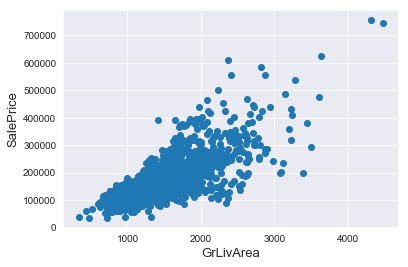

In [6]:
#Delete outliers
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [7]:
# number of training data and test data separately
ntrain, ntest = train.shape[0], test.shape[0]
y_train = train.SalePrice.values

In [8]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


# Feature Engineering

**1. Missing Data**

In [9]:
miss = all_data.isnull().sum()
miss[miss > 0].sort_values(ascending = False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

In [10]:
# Missing ratio of each feature
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

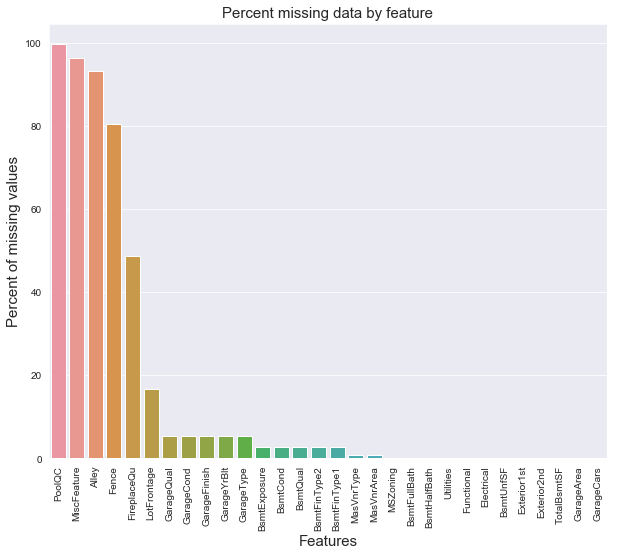

In [11]:
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

(1) fill with median

In [12]:
#LotFrontage: Linear feet of street connected to property
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

(2) fill with "None"

In [13]:
# GarageType: Garage location
#        2Types	More than one type of garage
#        Attchd	Attached to home
#        Basment	Basement Garage
#        BuiltIn	Built-In (Garage part of house - typically has room above garage)
#        CarPort	Car Port
#        Detchd	Detached from home
#        NA	No Garage
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', "MasVnrType", 'GarageType', 'GarageFinish',
            'GarageQual', 'GarageCond', "GarageYrBlt", "PoolQC", 
            "MiscFeature", "Alley", "Fence", "FireplaceQu"):
    all_data[col] = all_data[col].fillna('None')

(3) fill with 0

In [14]:
# MasVnrArea: Masonry veneer area in square feet
for col in ("MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", 
            "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"):
    all_data[col] = all_data[col].fillna(0)

(4) fill with mode

In [15]:
# MSSubClass: Identifies the type of dwelling involved in the sale.	
#         20	1-STORY 1946 & NEWER ALL STYLES
#         30	1-STORY 1945 & OLDER
#         40	1-STORY W/FINISHED ATTIC ALL AGES
#         45	1-1/2 STORY - UNFINISHED ALL AGES
#         50	1-1/2 STORY FINISHED ALL AGES
#         60	2-STORY 1946 & NEWER
#         70	2-STORY 1945 & OLDER
#         75	2-1/2 STORY ALL AGES
#         80	SPLIT OR MULTI-LEVEL
#         85	SPLIT FOYER
#         90	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES
for col in ("MSZoning", "BsmtFullBath", "BsmtHalfBath", 
         "Utilities", "Functional", "Electrical", 
         "KitchenQual", "SaleType","Exterior1st", 
         "Exterior2nd"):
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

In [16]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)

# no missing value in the training data and test data
print("The number of missing data: {}".format(all_data.isnull().sum().sum()))

The number of missing data: 0


**Categorical Features**

In [17]:
cols = ["MSSubClass","BsmtFullBath","BsmtHalfBath",
          "HalfBath","BedroomAbvGr","KitchenAbvGr",
          "MoSold","YrSold","YearBuilt","YearRemodAdd",
          "LowQualFinSF","GarageYrBlt"]
for col in cols:
    all_data[col] = all_data[col].astype(str)       

In [18]:
# using labelencoder to map categorical values to numerical values
le = LabelEncoder()
for c in cols:
    new_col = le.fit_transform(all_data[[c]])
    all_data["o" + c] = new_col

In [19]:
# deal with categorical features by mapping categorical values to numerical values
all_data["oMSSubClass"] = all_data.MSSubClass.map({'180':1, 
                                                   '30':2, '45':2, 
                                                   '190':3, '50':3, '90':3, 
                                                   '85':4, '40':4, '160':4, 
                                                   '70':5, '20':5, '75':5, '80':5, '150':5,
                                                   '120': 6, '60':6})

all_data["oMSZoning"] = all_data.MSZoning.map({'C (all)':1, 
                                               'RH':2, 'RM':2, 
                                               'RL':3, 
                                               'FV':4})

all_data["oNeighborhood"] = all_data.Neighborhood.map({'MeadowV':1,
                                                       'IDOTRR':2, 'BrDale':2,
                                                       'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                                       'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                                       'NPkVill':5, 'Mitchel':5,
                                                       'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                                       'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                                       'Veenker':8, 'Somerst':8, 'Timber':8,
                                                       'StoneBr':9,
                                                       'NoRidge':10, 'NridgHt':10})

all_data["oCondition1"] = all_data.Condition1.map({'Artery':1,
                                                   'Feedr':2, 'RRAe':2,
                                                   'Norm':3, 'RRAn':3,
                                                   'PosN':4, 'RRNe':4,
                                                   'PosA':5 ,'RRNn':5})

all_data["oBldgType"] = all_data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})

all_data["oHouseStyle"] = all_data.HouseStyle.map({'1.5Unf':1, 
                                                   '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                                   '1Story':3, 'SLvl':3,
                                                   '2Story':4, '2.5Fin':4})

all_data["oExterior1st"] = all_data.Exterior1st.map({'BrkComm':1,
                                                     'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                                     'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                                     'BrkFace':4, 'Plywood':4,
                                                     'VinylSd':5,
                                                     'CemntBd':6,
                                                     'Stone':7, 'ImStucc':7})

all_data["oMasVnrType"] = all_data.MasVnrType.map({'BrkCmn':1, 'None':1, 
                                                   'BrkFace':2, 
                                                   'Stone':3})

all_data["oExterQual"] = all_data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

all_data["oFoundation"] = all_data.Foundation.map({'Slab':1, 
                                                   'BrkTil':2, 'CBlock':2, 'Stone':2,
                                                   'Wood':3, 
                                                   'PConc':4})

all_data["oBsmtQual"] = all_data.BsmtQual.map({'None':1, 
                                               'Fa':2, 
                                               'TA':3, 
                                               'Gd':4, 
                                               'Ex':5})

all_data["oBsmtExposure"] = all_data.BsmtExposure.map({'None':1, 
                                                       'No':2, 
                                                       'Av':3, 'Mn':3, 
                                                       'Gd':4})

all_data["oHeating"] = all_data.Heating.map({'Floor':1, 'Grav':1, 
                                             'Wall':2, 
                                             'OthW':3, 
                                             'GasW':4, 
                                             'GasA':5})

all_data["oHeatingQC"] = all_data.HeatingQC.map({'Po':1, 
                                                 'Fa':2, 
                                                 'TA':3, 
                                                 'Gd':4, 
                                                 'Ex':5})

all_data["oKitchenQual"] = all_data.KitchenQual.map({'Fa':1, 
                                                     'TA':2, 
                                                     'Gd':3, 
                                                     'Ex':4})

all_data["oFunctional"] = all_data.Functional.map({'Maj2':1, 
                                                   'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 
                                                   'Typ':3})

all_data["oFireplaceQu"] = all_data.FireplaceQu.map({'None':1, 'Po':1, 
                                                     'Fa':2, 
                                                     'TA':3, 
                                                     'Gd':4, 
                                                     'Ex':5})

all_data["oGarageType"] = all_data.GarageType.map({'CarPort':1, 'None':1,
                                                   'Detchd':2,
                                                   '2Types':3, 'Basment':3,
                                                   'Attchd':4, 
                                                   'BuiltIn':5})

all_data["oGarageFinish"] = all_data.GarageFinish.map({'None':1, 
                                                       'Unf':2, 
                                                       'RFn':3, 
                                                       'Fin':4})

all_data["oPavedDrive"] = all_data.PavedDrive.map({'N':1, 
                                                   'P':2, 
                                                   'Y':3})

all_data["oSaleType"] = all_data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                               'CWD':2, 
                                               'Con':3, 'New':3})

all_data["oSaleCondition"] = all_data.SaleCondition.map({'AdjLand':1, 
                                                         'Abnorml':2, 'Alloca':2, 'Family':2, 
                                                         'Normal':3, 
                                                         'Partial':4})            

In [20]:
class labelenc:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        lab = LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [21]:
class skew_dummies:
    def __init__(self, skew=0.5):
        self.skew = skew
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_numeric = X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

However, combining attributes can provide higher correlation. In particular, if we sum the first floor and second floor areas, the result has a higher correlation than any single attribute alone. This high correlation indicates that we should try to use more than one attribute to predict the sale price. In a dataset with multiple observed attributes and a single numerical value to be predicted (the sale price in this case), multiple linear regression can be an effective technique.

In [22]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [23]:
# build a pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

# PCA

In [24]:
pipe_data = pipe.fit_transform(all_data)
pipe_data.shape

(2917, 437)

In [25]:
train_X = pipe_data[:ntrain]
test_X = pipe_data[ntrain:]
y = train.SalePrice

#Scale features using statistics that are robust to outliers.
robustscaler = RobustScaler()
train_X_scaled = robustscaler.fit(train_X).transform(train_X)
test_X_scaled = robustscaler.transform(test_X)
y_log = np.log(y)

In [26]:
# reduce the dimension to 400
pca = PCA(n_components=400)
train_X_scaled = pca.fit_transform(train_X_scaled)
test_X_scaled = pca.fit_transform(test_X_scaled)
print("The training data shape after PCA is : {} ".format(train_X_scaled.shape))
print("The test data shape after PCA is : {} ".format(test_X_scaled.shape))

The training data shape after PCA is : (1458, 400) 
The test data shape after PCA is : (1459, 400) 


# Model Construction

In [27]:
# define cross validation strategy
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 5))
    return rmse

In [28]:
# models
models = {
          "LR": LinearRegression(),
          "Ridge" : Ridge(alpha=60),
          "Lasso": Lasso(alpha=0.0005,max_iter=10000),
          "RF" : RandomForestRegressor(),
          "GBR" : GradientBoostingRegressor(),
          "SVR": SVR(gamma= 0.0004, kernel='rbf', C=13, epsilon=0.009),
          "Ela": ElasticNet(alpha=0.005, l1_ratio=0.08, max_iter=10000),
          "Bay": BayesianRidge(),
          "Ker": KernelRidge(alpha=0.2, kernel='polynomial', degree=3, coef0=0.8)
         }

In [29]:
for k, v in models.items():
    err = rmse_cv(v, train_X_scaled, y_log)
    print("{}: {:.4f}, {:.4f}".format(k, err.mean(), err.std()))

LR: 877120656.9807, 531453219.4491
Ridge: 0.1103, 0.0054
Lasso: 0.1117, 0.0064
RF: 0.1391, 0.0041
GBR: 0.1236, 0.0056
SVR: 0.1078, 0.0074
Ela: 0.1113, 0.0060
Bay: 0.1107, 0.0059
Ker: 0.1082, 0.0055


# Ensemble Methods

**Weight Average Model**

In [30]:
svr = SVR(gamma= 0.0004, kernel='rbf', C=13, epsilon=0.009)
ker = KernelRidge(alpha=0.2, kernel='polynomial', degree=3, coef0=0.8)

In [31]:
class AverageModel(BaseEstimator, RegressorMixin):
    def __init__(self, model, weight):
        self.model = model
        self.weight = weight
        
    def fit(self, X, y):
        self.models = [clone(x) for x in self.model]
        for model in self.models:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        res = list()
        pred = np.array([model.predict(X) for model in self.models])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data] * weight for model, weight in zip(range(pred.shape[0]),self.weight)]
            res.append(np.sum(single))
        return res

In [32]:
avg_model = AverageModel(model = [svr, ker], weight = [0.5, 0.5])

In [33]:
print("The cross-validation score of average model kel and svr: {}".
      format(rmse_cv(avg_model, train_X_scaled, y_log).mean()))

The cross-validation score of average model kel and svr: 0.10655573186062914


**Stacking Model**

In [34]:
ridge = Ridge(alpha=60)
lasso = Lasso(alpha=0.0005,max_iter=10000)
svr = SVR(gamma= 0.0004, kernel='rbf', C=13, epsilon=0.009)
ela = ElasticNet(alpha=0.005, l1_ratio=0.08, max_iter=10000)
bay = BayesianRidge()
ker = KernelRidge(alpha=0.2, kernel='polynomial', degree=3, coef0=0.8)

In [35]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [36]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay], meta_model=ker)

In [37]:
new_X = Imputer().fit_transform(train_X_scaled)
new_y = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [38]:
print("The cross-validation score of stack model: {}".
      format(rmse_cv(stack_model, new_X, new_y).mean()))

The cross-validation score of stack model: 0.10640690859298066


In [39]:
# new features
X_train_stack, X_test_stack = stack_model.get_oof(new_X, new_y, test_X_scaled)
X_train_stack.shape, X_test_stack.shape

((1458, 6), (1459, 6))

In [40]:
# add new features to the original data
X_train_final = np.hstack((new_X, X_train_stack))
X_test_final = np.hstack((test_X_scaled, X_test_stack))
X_train_final.shape, X_test_final.shape

((1458, 406), (1459, 406))

In [41]:
print("The cross-validation score of stack model after adding new features: {}".
      format(rmse_cv(stack_model, X_train_final, new_y).mean()))

The cross-validation score of stack model after adding new features: 0.10111936156382176


# Final Prediction

In [42]:
# This is the final model I use
stack_model = stacking(mod = [lasso,ridge,svr,ker,ela,bay], meta_model = ker)

In [43]:
# fit the model
stack_model.fit(new_X, new_y)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [44]:
#lg(pred+1) = np.exp(stack_model.predict(test_X_scaled))
pred = np.exp(stack_model.predict(test_X_scaled))-1

In [45]:
# The final result
result = pd.DataFrame({'Id': test_ID, 'SalePrice':pred})
result.head(10)

,Id,SalePrice
0,1461,235908.955
1,1462,169020.644
2,1463,137595.561
3,1464,147219.154
4,1465,125584.469
5,1466,143028.436
6,1467,151610.075
7,1468,140976.115
8,1469,140872.300
9,1470,225776.825



 mu = 12.02 and sigma = 0.39



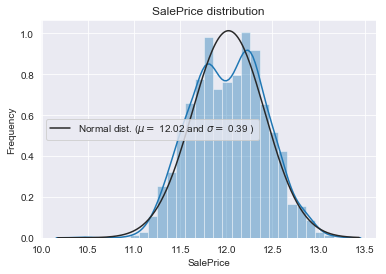

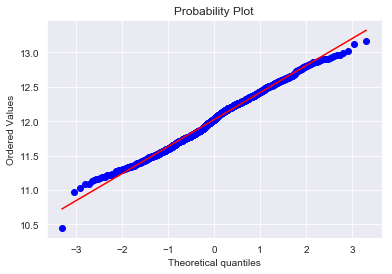

In [46]:
#We use the numpy fuction log1p which applies log(1+x) to all elements of the column
result["SalePrice"] = np.log1p(result["SalePrice"])

#Check the new distribution 
sns.distplot(result['SalePrice'] , fit = norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(result['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(result['SalePrice'], plot=plt)
plt.show()

In [47]:
# save the results to file Prediction.csv
result.to_csv("Prediction.csv", index=False)